# Environmental Sound Classification and Generation using Deep Learning

## 1. Business Understanding

The objective of this project is to classify environmental sounds using deep learning models on the ESC-50 dataset. This has practical applications in:
- Smart surveillance systems
- Assistive technologies for the hearing impaired
- Wildlife and urban monitoring
- Industrial sound diagnostics

We explore various architectures like CNN, AE, VAE, and ResNet for classifying 50 environmental sound categories.

In [3]:
from google.colab import drive
import zipfile
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to your zip file and where to extract it
zip_path = "/content/drive/My Drive/ESC-50-master.zip"
extract_path = "/content/ESC-50-master"

# Step 3: Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)

Mounted at /content/drive
✅ Extracted to: /content/ESC-50-master


In [4]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import librosa.display
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2. Data Understanding

In [5]:
# Set this to your actual file paths
AUDIO_FOLDER = "/content/ESC-50-master/ESC-50-master/audio"
CSV_PATH = "/content/ESC-50-master/ESC-50-master/meta/esc50.csv"

# Load metadata
metadata = pd.read_csv(CSV_PATH)

# Get audio file paths
def load_esc50(data_path):
    audio_files_path = []
    file_names = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                audio_files_path.append(file_path)
                file_names.append(file)
    return audio_files_path, file_names

audio_files_path, file_names = load_esc50(AUDIO_FOLDER)

audio_df = pd.DataFrame(zip(audio_files_path, file_names), columns=["path", "filename"])
df = audio_df.merge(metadata, on="filename")

3. Data Preparation

🔹 Duration Distribution

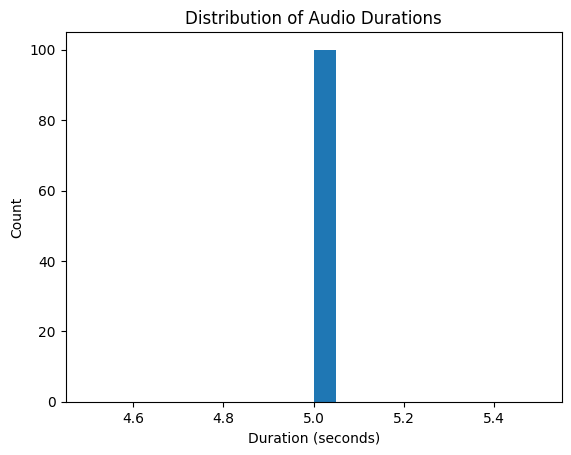

In [ ]:
durations = []
for path in df['path'].values[:100]:
    y, sr = librosa.load(path)
    durations.append(len(y)/sr)

plt.hist(durations, bins=20)
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations')
plt.show()


In [6]:
# View metadata summary
print("ESC-50 Dataset Summary:")
print(df.info())
print("\nSample entries:\n", df.head())

ESC-50 Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      1985 non-null   object
 1   filename  1985 non-null   object
 2   fold      1985 non-null   int64 
 3   target    1985 non-null   int64 
 4   category  1985 non-null   object
 5   esc10     1985 non-null   bool  
 6   src_file  1985 non-null   int64 
 7   take      1985 non-null   object
dtypes: bool(1), int64(3), object(4)
memory usage: 110.6+ KB
None

Sample entries:
                                                 path           filename  fold  \
0  /content/ESC-50-master/ESC-50-master/audio/2-2...  2-209472-A-25.wav     2   
1  /content/ESC-50-master/ESC-50-master/audio/2-3...   2-39945-A-19.wav     2   
2  /content/ESC-50-master/ESC-50-master/audio/5-2...  5-219379-C-11.wav     5   
3  /content/ESC-50-master/ESC-50-master/audio/4-1...   4-132383-B-2.wav     4   
4

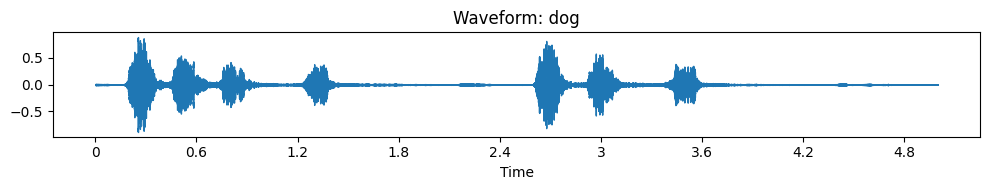

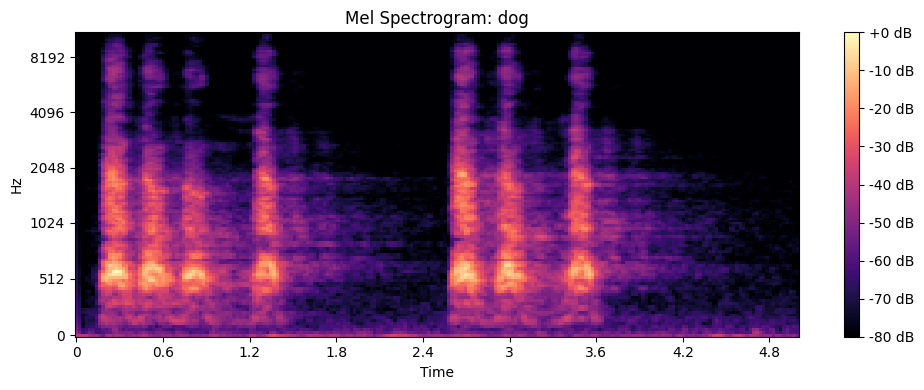

In [8]:
sample = df[df['category'] == 'dog'].iloc[0]  # Change category as needed
y, sr = librosa.load(sample['path'], sr=22050)

# Waveform
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {sample['category']}")
plt.tight_layout()
plt.show()

# Mel Spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram: {sample['category']}")
plt.tight_layout()
plt.show()

Data Processing

In [9]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [13]:
class SpecAugment(object):
    def __init__(self, time_mask=30, freq_mask=15, noise_factor=0.01):
        self.time_mask = T.TimeMasking(time_mask_param=time_mask, p=0.7)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.noise_factor = noise_factor

    def __call__(self, spectrogram):
        augmented = self.time_mask(spectrogram)
        augmented = self.freq_mask(augmented)
        noise = self.noise_factor * torch.randn_like(augmented)
        return augmented + noise

In [14]:
class ESC50MelSpecDataset(Dataset):
    def __init__(self, dataframe, apply_augment=False, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
        self.df = dataframe
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.label_encoder = LabelEncoder()
        self.df['target'] = self.label_encoder.fit_transform(self.df['category'])
        self.apply_augment = apply_augment
        self.augmenter = SpecAugment() if apply_augment else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, sr = librosa.load(row['path'], sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_tensor = torch.tensor(mel_spec_db).unsqueeze(0).float()

        if self.apply_augment:
            mel_spec_tensor = self.augmenter(mel_spec_tensor)

        return mel_spec_tensor, torch.tensor(row['target'])

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

train_dataset = ESC50MelSpecDataset(train_df, apply_augment=True)
test_dataset = ESC50MelSpecDataset(test_df, apply_augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Detect input shape
x, _ = train_dataset[0]
print("Input shape:", x.shape)

dummy = x.unsqueeze(0)
conv_test = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
)
with torch.no_grad():
    out = conv_test(dummy)
    flattened_size = out.view(1, -1).shape[1]
print("Flattened size:", flattened_size)

Input shape: torch.Size([1, 128, 216])
Flattened size: 27648


## 3. CNN Classifier (Model 1)
A custom-built Convolutional Neural Network is trained to classify environmental sounds from spectrogram inputs.

In [16]:
class CNNClassifier(nn.Module):
    def __init__(self, flattened_size, num_classes=50):
        super(CNNClassifier, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(flattened_size=flattened_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(30):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1} completed.")

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.


In [18]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Overall Accuracy
accuracy = 100 * correct / total
print(f"\n Test Accuracy: {accuracy:.2f}%\n")

class_names = df['category'].unique().tolist()

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


 Test Accuracy: 54.91%

Classification Report:
                  precision    recall  f1-score   support

       footsteps       0.17      0.12      0.14         8
    thunderstorm       0.33      0.25      0.29         8
       sea_waves       0.57      0.50      0.53         8
             pig       0.62      0.62      0.62         8
         snoring       0.71      0.62      0.67         8
 door_wood_knock       0.67      0.50      0.57         8
        crickets       0.67      0.50      0.57         8
            crow       0.67      0.50      0.57         8
 washing_machine       0.86      0.75      0.80         8
   pouring_water       0.40      0.29      0.33         7
           siren       0.67      0.75      0.71         8
      helicopter       0.36      0.62      0.45         8
           train       0.62      0.62      0.62         8
drinking_sipping       0.75      0.75      0.75         8
       fireworks       0.43      0.38      0.40         8
        coughing       

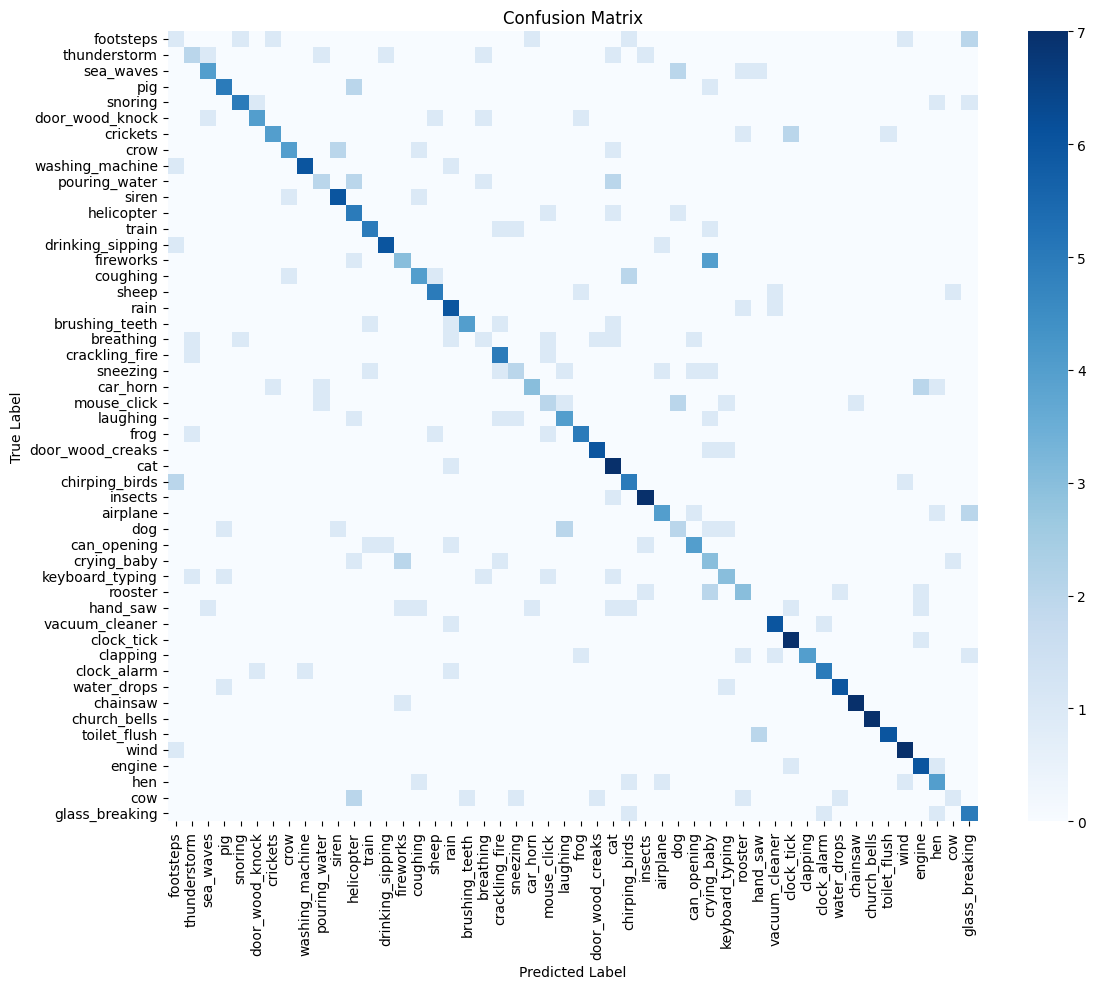


 Per-Class Accuracy:
footsteps                : 12.50%
thunderstorm             : 25.00%
sea_waves                : 50.00%
pig                      : 62.50%
snoring                  : 62.50%
door_wood_knock          : 50.00%
crickets                 : 50.00%
crow                     : 50.00%
washing_machine          : 75.00%
pouring_water            : 28.57%
siren                    : 75.00%
helicopter               : 62.50%
train                    : 62.50%
drinking_sipping         : 75.00%
fireworks                : 37.50%
coughing                 : 50.00%
sheep                    : 62.50%
rain                     : 75.00%
brushing_teeth           : 50.00%
breathing                : 12.50%
crackling_fire           : 71.43%
sneezing                 : 25.00%
car_horn                 : 37.50%
mouse_click              : 25.00%
laughing                 : 50.00%
frog                     : 62.50%
door_wood_creaks         : 75.00%
cat                      : 87.50%
chirping_birds           :

In [19]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Accuracy per Class
print("\n Per-Class Accuracy:")
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

for i, class_name in enumerate(class_names):
    idx = (y_true_np == i)
    if np.sum(idx) > 0:
        class_acc = np.mean(y_pred_np[idx] == i)
        print(f"{class_name:25s}: {class_acc * 100:.2f}%")
    else:
        print(f"{class_name:25s}: No samples found")

## 4. ResNet50 Transfer Learning (Model 2)
A pretrained ResNet50 model is fine-tuned to classify sounds, using spectrograms converted to 3-channel RGB images.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

class SpecAugment:
    def __init__(self, noise_factor=0.01):
        self.noise_factor = noise_factor

    def __call__(self, spec):
        noise = self.noise_factor * torch.randn_like(spec)
        return spec + noise

In [25]:
class ESC50ImageDataset(Dataset):
    def __init__(self, dataframe, apply_augment=False, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
        self.df = dataframe
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.label_encoder = LabelEncoder()
        self.df['target'] = self.label_encoder.fit_transform(self.df['category'])
        self.apply_augment = apply_augment
        self.augmenter = SpecAugment() if apply_augment else None

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, sr = librosa.load(row['path'], sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels,
                                                  n_fft=self.n_fft, hop_length=self.hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_tensor = torch.tensor(mel_spec_db).unsqueeze(0).float()

        if self.apply_augment:
            mel_tensor = self.augmenter(mel_tensor)

        image_tensor = mel_tensor.expand(3, -1, -1)
        image_tensor = self.transform(image_tensor)

        return image_tensor, torch.tensor(row['target'])

In [26]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=50):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for name, param in self.resnet.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)
train_dataset = ESC50ImageDataset(train_df, apply_augment=True)
test_dataset = ESC50ImageDataset(test_df, apply_augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
resnet_model = ResNetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(30):
    resnet_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"[Epoch {epoch+1}] Loss: {total_loss/len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 2.3279
[Epoch 2] Loss: 0.9092
[Epoch 3] Loss: 0.4950
[Epoch 4] Loss: 0.3304
[Epoch 5] Loss: 0.2143
[Epoch 6] Loss: 0.1614
[Epoch 7] Loss: 0.1058
[Epoch 8] Loss: 0.1119
[Epoch 9] Loss: 0.1478
[Epoch 10] Loss: 0.1575
[Epoch 11] Loss: 0.0722
[Epoch 12] Loss: 0.0294
[Epoch 13] Loss: 0.0116
[Epoch 14] Loss: 0.0091
[Epoch 15] Loss: 0.0071
[Epoch 16] Loss: 0.0065
[Epoch 17] Loss: 0.0046
[Epoch 18] Loss: 0.0059
[Epoch 19] Loss: 0.0045
[Epoch 20] Loss: 0.0071
[Epoch 21] Loss: 0.0033
[Epoch 22] Loss: 0.0034
[Epoch 23] Loss: 0.0049
[Epoch 24] Loss: 0.0062
[Epoch 25] Loss: 0.0029
[Epoch 26] Loss: 0.0023
[Epoch 27] Loss: 0.0024
[Epoch 28] Loss: 0.0019
[Epoch 29] Loss: 0.0028
[Epoch 30] Loss: 0.0023


In [28]:
resnet_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())




✅ ResNet Test Accuracy: 84.89%

📊 ResNet Classification Report:
                  precision    recall  f1-score   support

       footsteps       0.78      0.88      0.82         8
    thunderstorm       1.00      0.88      0.93         8
       sea_waves       1.00      0.88      0.93         8
             pig       0.62      0.62      0.62         8
         snoring       0.75      0.75      0.75         8
 door_wood_knock       1.00      0.75      0.86         8
        crickets       0.88      0.88      0.88         8
            crow       0.88      0.88      0.88         8
 washing_machine       0.86      0.75      0.80         8
   pouring_water       1.00      0.57      0.73         7
           siren       0.67      1.00      0.80         8
      helicopter       0.75      0.75      0.75         8
           train       1.00      0.75      0.86         8
drinking_sipping       1.00      0.88      0.93         8
       fireworks       0.89      1.00      0.94         8
      

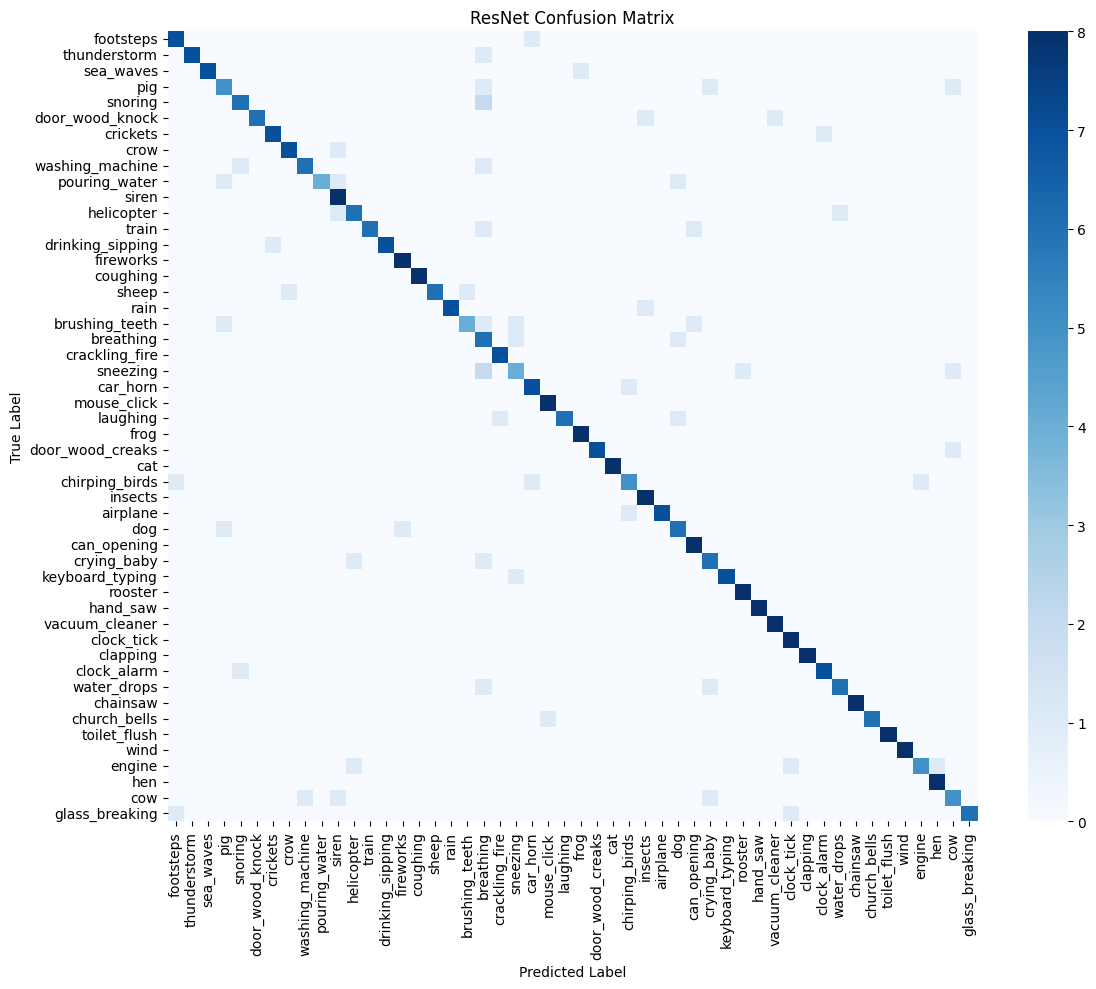


🎯 ResNet Per-Class Accuracy:
footsteps                : 87.50%
thunderstorm             : 87.50%
sea_waves                : 87.50%
pig                      : 62.50%
snoring                  : 75.00%
door_wood_knock          : 75.00%
crickets                 : 87.50%
crow                     : 87.50%
washing_machine          : 75.00%
pouring_water            : 57.14%
siren                    : 100.00%
helicopter               : 75.00%
train                    : 75.00%
drinking_sipping         : 87.50%
fireworks                : 100.00%
coughing                 : 100.00%
sheep                    : 75.00%
rain                     : 87.50%
brushing_teeth           : 50.00%
breathing                : 75.00%
crackling_fire           : 100.00%
sneezing                 : 50.00%
car_horn                 : 87.50%
mouse_click              : 100.00%
laughing                 : 75.00%
frog                     : 100.00%
door_wood_creaks         : 87.50%
cat                      : 100.00%
chirping_bi

In [29]:
# Overall Accuracy
accuracy = 100 * correct / total
print(f"\n✅ ResNet Test Accuracy: {accuracy:.2f}%\n")

class_names = df['category'].unique().tolist()

# Classification Report
print("📊 ResNet Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Accuracy per Class
print("\n🎯 ResNet Per-Class Accuracy:")
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

for i, class_name in enumerate(class_names):
    idx = (y_true_np == i)
    if np.sum(idx) > 0:
        class_acc = np.mean(y_pred_np[idx] == i)
        print(f"{class_name:25s}: {class_acc * 100:.2f}%")
    else:
        print(f"{class_name:25s}: No samples found")

## 5. Autoencoder for Sound Reconstruction (Model 3)
An autoencoder is trained to compress and reconstruct Mel spectrograms, demonstrating the ability to regenerate sound features.

In [30]:
class ESC50MelSpecDataset(Dataset):
    def __init__(self, dataframe, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
        self.df = dataframe
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.label_encoder = LabelEncoder()
        self.df['target'] = self.label_encoder.fit_transform(self.df['category'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, sr = librosa.load(row['path'], sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft,
                                                  hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_db = mel_spec_db.astype(np.float32)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=0)
        return torch.tensor(mel_spec_db), torch.tensor(row['target'])

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

ae_train_dataset = ESC50MelSpecDataset(train_df)
ae_test_dataset = ESC50MelSpecDataset(test_df)

ae_train_loader = DataLoader(ae_train_dataset, batch_size=16, shuffle=True)
ae_test_loader = DataLoader(ae_test_dataset, batch_size=16, shuffle=False)

In [32]:
class SoundAutoencoder(nn.Module):
    def __init__(self):
        super(SoundAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
autoencoder = SoundAutoencoder().to(device)
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(20):
    autoencoder.train()
    epoch_loss = 0
    for inputs, _ in ae_train_loader:
        inputs = inputs.to(device)
        ae_optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = ae_criterion(outputs, inputs)
        loss.backward()
        ae_optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(ae_train_loader):.4f}")

Epoch 1, Loss: 0.0408
Epoch 2, Loss: 0.0064
Epoch 3, Loss: 0.0052
Epoch 4, Loss: 0.0046
Epoch 5, Loss: 0.0041
Epoch 6, Loss: 0.0039
Epoch 7, Loss: 0.0037
Epoch 8, Loss: 0.0036
Epoch 9, Loss: 0.0034
Epoch 10, Loss: 0.0034
Epoch 11, Loss: 0.0033
Epoch 12, Loss: 0.0032
Epoch 13, Loss: 0.0032
Epoch 14, Loss: 0.0031
Epoch 15, Loss: 0.0031
Epoch 16, Loss: 0.0030
Epoch 17, Loss: 0.0030
Epoch 18, Loss: 0.0029
Epoch 19, Loss: 0.0029
Epoch 20, Loss: 0.0028


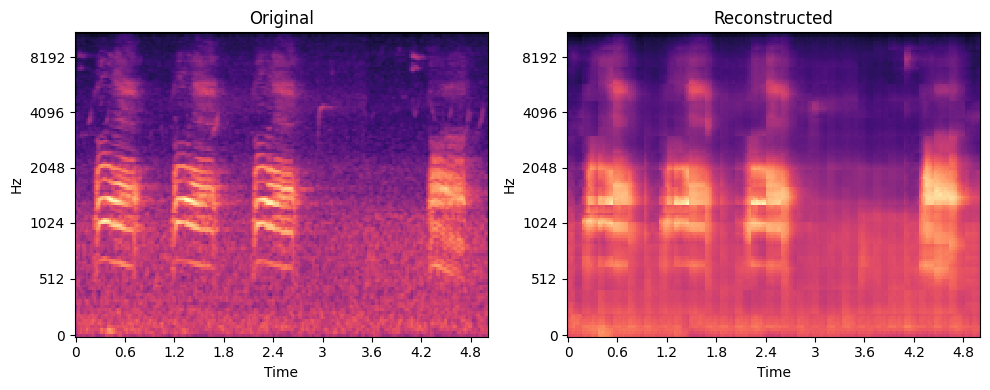

In [34]:
autoencoder.eval()

sample_input, _ = ae_test_dataset[31]  # Change index if needed
sample_input = sample_input.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    reconstructed = autoencoder(sample_input).cpu().squeeze().numpy()
    original = sample_input.cpu().squeeze().numpy()

# Plot original vs reconstructed
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
librosa.display.specshow(original, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
plt.title("Original")

plt.subplot(1, 2, 2)
librosa.display.specshow(reconstructed, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
plt.title("Reconstructed")

plt.tight_layout()
plt.show()

In [35]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

total_mse = 0.0
total_psnr = 0.0
total_ssim = 0.0
num_samples = 0

autoencoder.eval()
with torch.no_grad():
    for inputs, _ in ae_test_loader:
        inputs = inputs.to(device)
        outputs = autoencoder(inputs).cpu().numpy()
        originals = inputs.cpu().numpy()

        for i in range(outputs.shape[0]):
            recon = outputs[i, 0]      # shape: (128, 431)
            orig = originals[i, 0]     # shape: (128, 431)

            mse_val = np.mean((recon - orig) ** 2)
            psnr_val = psnr(orig, recon, data_range=1.0)
            ssim_val = ssim(orig, recon, data_range=1.0)

            total_mse += mse_val
            total_psnr += psnr_val
            total_ssim += ssim_val
            num_samples += 1

# Average Metrics
avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\n Autoencoder Evaluation on Test Set:")
print(f" Avg MSE:   {avg_mse:.6f}")
print(f" Avg PSNR:  {avg_psnr:.2f} dB")
print(f" Avg SSIM:  {avg_ssim:.4f}")


 Autoencoder Evaluation on Test Set:
 Avg MSE:   0.002929
 Avg PSNR:  26.09 dB
 Avg SSIM:  0.6171


## 6. Variational Autoencoder (VAE) for Sound Generation (Model 4)
The VAE learns a latent space from spectrograms and can generate new sounds by sampling from it.

In [36]:
class ImprovedVAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 216), latent_dim=128):
        super(ImprovedVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 x 108

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32 x 54

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 16 x 27
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy_out = self.encoder(dummy)
            self.conv_out_shape = dummy_out.shape[1:]  # (128, 16, 27)
            self.flattened_size = dummy_out.view(1, -1).shape[1]

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=(1, 1)), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=(1, 1)), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=(1, 1)), nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, *self.conv_out_shape)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [37]:
def improved_vae_loss(recon_x, x, mu, logvar, kl_weight=1e-5):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_div

In [38]:
vae = ImprovedVAE(input_shape=(1, 128, 216)).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

for epoch in range(40):
    vae.train()
    total_loss = 0
    for inputs, _ in ae_train_loader:
        inputs = inputs.to(device)
        vae_optimizer.zero_grad()

        recon, mu, logvar = vae(inputs)
        recon_loss = nn.functional.mse_loss(recon, inputs, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + 1e-5 * kl_div

        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        vae_optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Total Loss: {total_loss / len(ae_train_loader):.2f} | Recon Loss: {recon_loss.item():.2f} | KL Div: {kl_div.item():.2f}")

[Epoch 1] Total Loss: 25190.86 | Recon Loss: 2340.28 | KL Div: 73483.13
[Epoch 2] Total Loss: 9699.62 | Recon Loss: 1968.76 | KL Div: 80105.06
[Epoch 3] Total Loss: 6882.84 | Recon Loss: 1434.02 | KL Div: 79918.50
[Epoch 4] Total Loss: 5579.71 | Recon Loss: 1368.51 | KL Div: 74746.01
[Epoch 5] Total Loss: 4959.35 | Recon Loss: 2099.12 | KL Div: 70566.39
[Epoch 6] Total Loss: 4678.59 | Recon Loss: 1158.22 | KL Div: 96847.70
[Epoch 7] Total Loss: 4287.07 | Recon Loss: 819.44 | KL Div: 86689.38
[Epoch 8] Total Loss: 4103.75 | Recon Loss: 1282.52 | KL Div: 79059.66
[Epoch 9] Total Loss: 3989.80 | Recon Loss: 2391.42 | KL Div: 75592.12
[Epoch 10] Total Loss: 3747.02 | Recon Loss: 921.05 | KL Div: 81975.31
[Epoch 11] Total Loss: 3622.05 | Recon Loss: 1868.39 | KL Div: 81428.20
[Epoch 12] Total Loss: 3506.69 | Recon Loss: 1634.72 | KL Div: 80139.11
[Epoch 13] Total Loss: 3529.03 | Recon Loss: 1684.90 | KL Div: 74321.18
[Epoch 14] Total Loss: 3456.30 | Recon Loss: 938.18 | KL Div: 91438.59
[Ep

In [39]:
import IPython.display as ipd

sample, _ = ae_test_dataset[31]
sample = sample.unsqueeze(0).to(device)

vae.eval()
with torch.no_grad():
    recon, _, _ = vae(sample)

# tensors to numpy
original_np = sample.squeeze().cpu().numpy()
reconstructed_np = recon.squeeze().cpu().detach().numpy()

# To dB
original_db = original_np * 80.0 - 80.0
reconstructed_db = reconstructed_np * 80.0 - 80.0

# dB → Power
original_power = librosa.db_to_power(original_db)
reconstructed_power = librosa.db_to_power(reconstructed_db)

# Mel → Audio
original_audio = librosa.feature.inverse.mel_to_audio(original_power, sr=22050, n_fft=2048, hop_length=512, win_length=2048, n_iter=64)
reconstructed_audio = librosa.feature.inverse.mel_to_audio(reconstructed_power, sr=22050, n_fft=2048, hop_length=512, win_length=2048, n_iter=64)

# Play both
print("🔊 Original Audio:")
display(ipd.Audio(original_audio, rate=22050))

print("🔊 Reconstructed Audio (VAE):")
display(ipd.Audio(reconstructed_audio, rate=22050))


🔊 Original Audio:


🔊 Reconstructed Audio (VAE):
